In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv('..\\Data\\healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<Axes: >

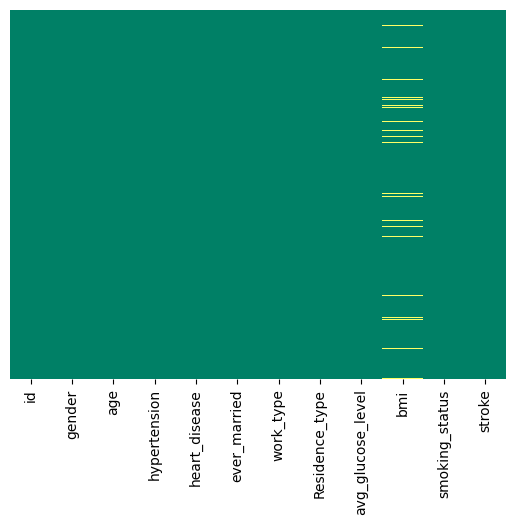

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='summer')

In [6]:
df["bmi"]=df["bmi"].fillna(df["bmi"].mean())

<Axes: >

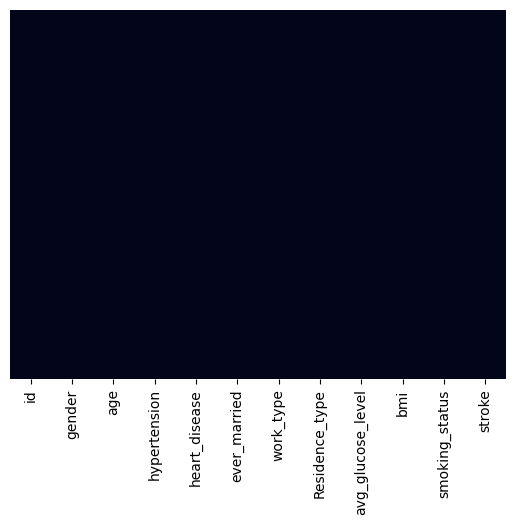

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [8]:
df_numerical = ['id','hypertension','heart_disease','age','avg_glucose_level','bmi','stroke']
df_categorical = ['gender','ever_married','work_type','Residence_type','smoking_status']

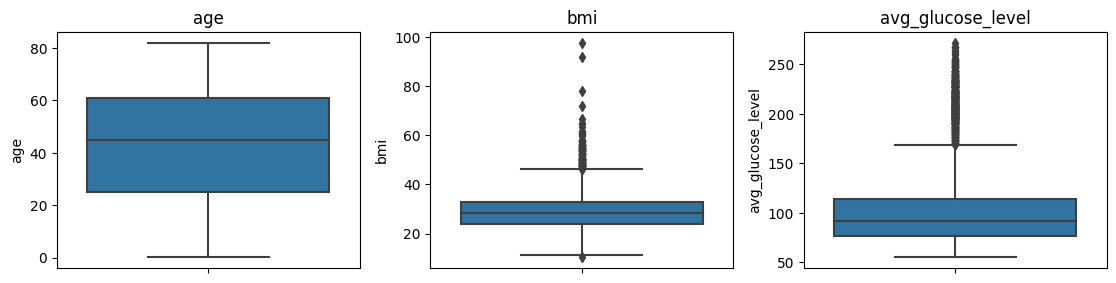

In [9]:
plt.figure(figsize=(15,8))
for i, j in enumerate(['age','bmi','avg_glucose_level']):
  plt.subplot(3,4,i+1)
  sns.boxplot(y=df[j])
  plt.title(f"{j}")
plt.tight_layout()
plt.show()

In [10]:
l = ["bmi","avg_glucose_level",'age']
clist = list()
def outlier_counter(l):    
    for i in l:
        count = 0
        Q1  = df[i].quantile(0.25)
        Q3  = df[i].quantile(0.75)
        IQR = Q3-Q1
        Uper = Q3+1.5*IQR
        lower = Q1-1.5*IQR
        for j in range(df.shape[0]):
            if df[i][j] > Uper:
                count += 1
        clist.append(count)
    return clist
con = outlier_counter(l)
print(f"Outlier count: \nBMI = {con[0]}\navg_glucose_level = {con[1]}\nage = {con[2]}")

Outlier count: 
BMI = 125
avg_glucose_level = 627
age = 0


In [11]:
def outlier_removal(l):
    for i in l:
        Q1  = df[i].quantile(0.25)
        Q3  = df[i].quantile(0.75)
        IQR = Q3-Q1
        Uper = Q3+1.5 * IQR
        lower = Q1-1.5 * IQR
        df[i]  = np.where(df[i]>Uper,Uper,(np.where(df[i]<lower,lower,df[i])))
outlier_removal(l)

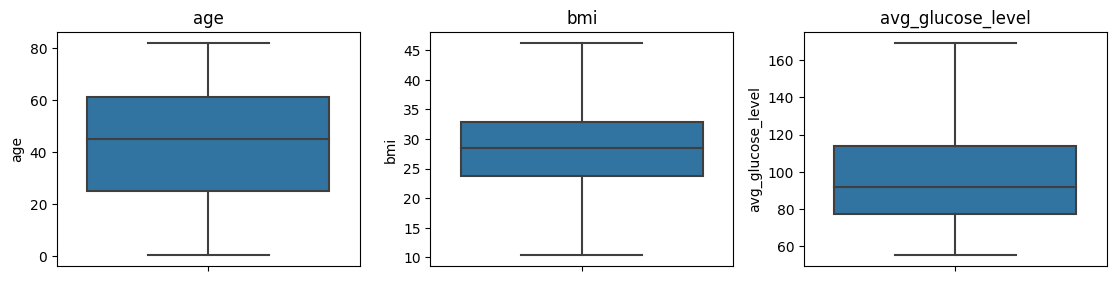

In [12]:
plt.figure(figsize=(15,8))
for i, j in enumerate(['age','bmi','avg_glucose_level']):
  plt.subplot(3,4,i+1)
  sns.boxplot(y=df[j])
  plt.title(f"{j}")
plt.tight_layout()
plt.show()

In [13]:
one_hot=["gender","ever_married","Residence_type","work_type","smoking_status"]
df=pd.get_dummies(df,columns=one_hot,dtype='int64')

In [14]:
df.sample()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2738,57047,43.0,0,0,110.42,32.6,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1


In [15]:
df.shape

(5110, 23)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

In [17]:
x = df.drop(['stroke'],axis=1)
x

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,...,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,169.3575,36.600000,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,51676,61.0,0,0,169.3575,28.893237,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.9200,32.500000,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,169.3575,34.400000,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,1665,79.0,1,0,169.3575,24.000000,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.7500,28.893237,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
5106,44873,81.0,0,0,125.2000,40.000000,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
5107,19723,35.0,0,0,82.9900,30.600000,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.2900,25.600000,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [18]:
y = df['stroke']
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [20]:
nm=NearMiss(n_neighbors=5,sampling_strategy='majority',version=1)
x_resampled,y_resampled=nm.fit_resample(x_scaled,y)

In [21]:
xtrain,xtest,ytrain,ytest = train_test_split(x_resampled, y_resampled, test_size=0.1, random_state=3)
print(xtrain.shape)
print(xtest.shape)

(448, 22)
(50, 22)


In [22]:
models = [
    (RandomForestClassifier, {"n_estimators": 100, "random_state": 42}),
    (DecisionTreeClassifier, {"random_state": 42}),
    (GradientBoostingClassifier, {"random_state": 42}),
    (AdaBoostClassifier, {"n_estimators": 50, "random_state": 42}),
    (xgb.XGBClassifier, {"n_estimators": 100, "random_state": 42}),
    (LogisticRegression, {"max_iter": 1000, "random_state": 42}),
    (SVC, {"kernel": "linear"}),
    (KNeighborsClassifier, {"n_neighbors": 5}),
    (GaussianNB,{})]
results = {}
for model_class, model_params in models:
    model = model_class(**model_params)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    model_name = model_class.__name__
    results[model_name] = accuracy
for model_name, accuracy in results.items():
    print(f"{model_name}: Accuracy = {accuracy}")

RandomForestClassifier: Accuracy = 0.86
DecisionTreeClassifier: Accuracy = 0.78
GradientBoostingClassifier: Accuracy = 0.92
AdaBoostClassifier: Accuracy = 0.88
XGBClassifier: Accuracy = 0.88
LogisticRegression: Accuracy = 0.84
SVC: Accuracy = 0.84
KNeighborsClassifier: Accuracy = 0.84
GaussianNB: Accuracy = 0.76


## Gradient Boost Fit

In [23]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 5, 7]
# }
# model = GradientBoostingClassifier()
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(xtrain,ytrain)
# print(grid_search.best_params_)

In [24]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.01)
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
print("Test prediction accuracy =",np.mean(ypred == ytest)*100)
print(classification_report(ytest,ypred))

Test prediction accuracy = 90.0
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.95      0.82      0.88        22

    accuracy                           0.90        50
   macro avg       0.91      0.89      0.90        50
weighted avg       0.90      0.90      0.90        50

